Add imports

In [408]:
import random
import torch
import math
from datasets import load_dataset
import sentencepiece as spm
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb
import uuid
from sklearn.model_selection import train_test_split
import numpy as np

Set hyperparameters

In [409]:

embedding_size = 512
hidden_layer_size = 512
batch_size = 10
num_epochs = 70
vocab_size = 102
# max_sequence_length = 4123
learning_rate= 0.01
data_sample_size = 100
uuid = random_uuid = uuid.uuid4()

torch.manual_seed(42)

Load the dataset and train sentencepiece on it

In [410]:
dataset = load_dataset("roneneldan/TinyStories")
sample_data = dataset["train"]['text'][:data_sample_size]

max_sequence_length = max(len(sentence) for sentence in train_data)
print(max_sequence_length)

with open('sentences.txt', 'w') as f:
    for sentence in sample_data:
        f.write(sentence + '\n')  # Write the sentence to the file with a newline

# with open("sentences.txt", "r") as f:
#     lines = f.readlines()

# lines = [line for line in lines if line.strip()]

# with open("sentences.txt", "w") as f:
#     f.writelines(lines)

input_file = 'sentences.txt' 
prefix = 'sentences'

spm.SentencePieceTrainer.train(
    input=input_file, 
    model_prefix=prefix, 
    vocab_size=vocab_size
)

Repo card metadata block was not found. Setting CardData to empty.


1005


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: sentences.txt
  input_format: 
  model_prefix: sentences
  model_type: UNIGRAM
  vocab_size: 102
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level:

In [411]:
#define and initialise the sentencepiece tokenizer
class SentencePieceTokenizer:
    def __init__(self, model_path):
        self.tokenizer = spm.SentencePieceProcessor(model_file=model_path)

    def encode(self, text):
        return self.tokenizer.encode(text, out_type=int)
    
    def decode(self, tokens):
        return self.tokenizer.decode_pieces(tokens)

model_path = "sentences.model"
sentence_piece_tokenizer = SentencePieceTokenizer(model_path)


In [412]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self):
    f = open('sentences.txt', 'r')
    self.stories = f.read().split('\n')
    f.close()

  def __len__(self):
    return len(self.stories)

  def __getitem__(self, idx):
    story = self.stories[idx]
    return torch.tensor(sentence_piece_tokenizer.encode(story))
  
def collate_fn(batch):
    # Sort batch by sequence length (descending order)
    batch = sorted(batch, key=lambda x: len(x), reverse=True)
    # Pad sequences to the same length
    padded_sequences = pad_sequence(batch, batch_first=True, padding_value=0)
    return padded_sequences


ds = Dataset()
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


Create the simple transformer

In [413]:
class SingleHeadSelfAttention(torch.nn.Module):
    def __init__(self, embed_size):
        super(SingleHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        # Mask tensor trick
        self.register_buffer('mask', torch.tril(torch.ones(max_sequence_length, max_sequence_length)))

        self.query = torch.nn.Linear(embed_size, embed_size)
        self.key = torch.nn.Linear(embed_size, embed_size)
        self.value = torch.nn.Linear(embed_size, embed_size)

    def forward(self, embeddings):
        # Linear transformations to obtain query, key, and value
        queries = self.query(embeddings)
        keys = self.key(embeddings)
        values = self.value(embeddings)

        # Compute attention scores
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores_scaled = attention_scores / np.sqrt(self.embed_size)  # Apply scaling

        msk = self.mask[0:x.shape[0], 0:x.shape[0]]
        attention_masked = attention_scores_scaled.masked_fill(msk == 0, float('-inf'))

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_masked, dim=-1)

        # Weighted sum of values to get attended representation
        attended_representation = torch.matmul(attention_weights, values)

        return attended_representation

        

In [414]:
class AmberSimpleTransformer(torch.nn.Module):
  def __init__(self):
    super(AmberSimpleTransformer, self).__init__()
    # Embedding part of the model
    self.embedding    = torch.nn.Embedding(vocab_size, embedding_size)
    self.pos_emb      = self.get_pos_matrix()

    # attentions & norm
    self.self_attention_00 = SingleHeadSelfAttention(embedding_size)
    self.layer_norm_00 = torch.nn.LayerNorm(embedding_size) #is it ok for both to use the same layernorm? 

    self.self_attention_01 = SingleHeadSelfAttention(embedding_size)
    self.layer_norm_01 = torch.nn.LayerNorm(embedding_size) #is it ok for both to use the same layernorm? 
    
    #feedforward&norm
    self.feedforward = torch.nn.Sequential(
            torch.nn.Linear(embedding_size, 2048),  # d_ff = 2048
            torch.nn.ReLU(),
            torch.nn.Linear(2048, embedding_size),
        )   
    self.norm = torch.nn.LayerNorm(embedding_size)

    # last linear layer
    self.map_to_vocab = torch.nn.Linear(embedding_size, vocab_size)

  def forward(self, x):
    emb = self.embedding(x) #embedding_size --> this will output something of d sequence length times embedding size 
    pos = self.pos_emb[0:x.shape[0], :]
    emb = emb + pos # add positional information to the embedding 

    # masked sa + add&norm
    res_0 = self.self_attention_00(emb)
    res_0 = self.layer_norm_00(emb + res_0)

    # masked sa + add&norm
    res_1 = self.self_attention_01(res_0)
    res_1 = self.layer_norm_01(res_0 + res_1)

    #feed forward + add&norm
    final_res = self.feedforward(res_1)
    final_res = self.norm(final_res)

    #linear then softmax
    out = self.map_to_vocab(final_res)
    # out = F.softmax(out, dim=-1) ---> Cross-entropy-loss does softmax, so we don't want to softmax before output
    return out



  def get_pos_matrix(self):
    store = torch.zeros(max_sequence_length, embedding_size)
    for pos in range(max_sequence_length):
      for i in range(0, embedding_size, 2):
        denominator = 10000 ** (2 * i / embedding_size)
        store[pos, i] = math.sin(pos / denominator)
        if i + 1 < embedding_size: store[pos, i + 1] = math.cos(pos / denominator)
    return store

Initialise and train the transformer

In [415]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="amber-transformer",
    
#     # track hyperparameters and run metadata
#     config= {
#     "architecture": "transformer",
#     "dataset": "roneneldan/TinyStories",
#     "embedding_size":embedding_size,
#     "hidden_layer_size": hidden_layer_size, 
#     "batch_size": batch_size,
#     "num_epochs": num_epochs,
#     "vocab_size":vocab_size,
#     "learning_rate":learning_rate,
#     "data_sample_size": data_sample_size,
#     "optimiser": "adam",
#     "uuid": uuid
#     }
# )

In [416]:
m = AmberSimpleTransformer()
opt = torch.optim.Adam(m.parameters(), lr=learning_rate)
print("num_params:", sum(p.numel() for p in m.parameters()))


losses = []
for _ in range(10000):
  for idx, batch in enumerate(dl):

    m.train()
    # print("batch[0]", idx, batch[0])
    sos = torch.tensor([2])
    eos = torch.tensor([1])
    if idx == 2: break

    x = batch[0]
    x = torch.cat([sos, x])
    y = torch.cat([x[1:], eos])
    
    # inspect batch 
    # print(sentence_piece_tokenizer.decode(x.tolist()))

    p = m(x)
    l = torch.nn.functional.cross_entropy(p, y)
    print("Loss:", l.item())
    if idx%1000 == 0:
      losses.append(l.item())
    l.backward()
    opt.step()
    opt.zero_grad()

print(type(losses))

# torch.save(m, f'models/{uuid}_final.pth')
  

num_params: 3783270
Loss: 4.649833679199219
Loss: 7.611556053161621
Loss: 4.58792781829834
Loss: 5.558635711669922
Loss: 5.754090309143066
Loss: 5.897739887237549
Loss: 6.408228397369385
Loss: 5.762607097625732
Loss: 6.0188212394714355
Loss: 5.5475006103515625
Loss: 5.067815780639648
Loss: 4.600011825561523
Loss: 4.384387016296387
Loss: 5.199957370758057
Loss: 5.103014945983887
Loss: 5.3800249099731445
Loss: 4.817124843597412
Loss: 4.479198932647705
Loss: 4.653329849243164
Loss: 4.248904705047607
Loss: 4.574100017547607
Loss: 4.623258590698242
Loss: 4.519676685333252
Loss: 4.379165172576904
Loss: 4.40183162689209
Loss: 4.227741241455078
Loss: 4.498483180999756
Loss: 4.308802604675293
Loss: 4.219172954559326
Loss: 4.158656120300293
Loss: 4.108094692230225
Loss: 4.313732624053955
Loss: 4.328035354614258
Loss: 4.272812366485596
Loss: 4.025577068328857
Loss: 4.361980438232422
Loss: 4.062005043029785
Loss: 4.339924335479736
Loss: 4.069060325622559
Loss: 4.260838985443115
Loss: 3.80620217323

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

Map the losses to see how well the training has gone

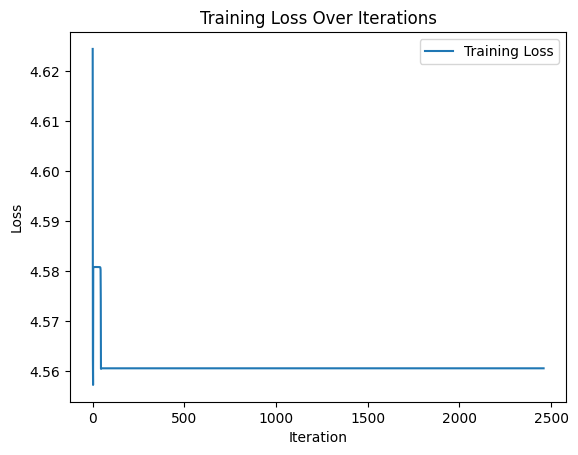

In [ ]:
# Plot the losses
plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.show()

Define different sampling strategies (how do you choose the next token)

In [ ]:
#define different sampling approaches to test out
def greedy_decode(next_token_options, x):
  next_token = torch.argmax(next_token_options) # find index of maximum value in each row 
  x = torch.cat([x, next_token.unsqueeze(0)]) #here we're just adding the last, converted to 2D
  return x

def random_sample(next_token_options, x):
  next_token = torch.multinomial(next_token_options, 1)  # Sample the next token using a multinomial distribution
  x = torch.cat([x, next_token])  # Add the sampled token to the sequence
  return x

def top_k_sample(next_token_options, x, k=5):
  top_k_values, top_k_indices = torch.topk(next_token_options, k)  # Get the top-k values and indices
  next_token = top_k_indices[torch.randint(k, (1,))]
  x = torch.cat([x, next_token])  # Add the selected token to the sequence
  return x

Generate some text from a random start token

In [ ]:
m.eval()
for _ in range(0,10):
  random_start_token = random.randint(3, vocab_size-1)
  x = sentence_piece_tokenizer.decode([random_start_token])
  x = torch.cat([sos, torch.tensor(sentence_piece_tokenizer.encode(x))])
  print("find next token after:", sentence_piece_tokenizer.decode(x.tolist()))
  while True:
    p = m(x) #logits
    p = torch.nn.functional.softmax(p, dim=1) #convert logits to likelihood out of 1
    next_token_options = p[-1]
    x = greedy_decode(next_token_options, x)
    if x[-1] == 1 or len(p.tolist()) == 30: break #stop generating if last token is end token or sequence len is 17
  print("Generate:", sentence_piece_tokenizer.decode(x.tolist()))

find next token after: ne
Generate: ne                            
find next token after: th
Generate: th                             
find next token after: T
Generate: T                             
find next token after: k
Generate: k                            
find next token after: u
Generate: u                            
find next token after: o
Generate: o                             
find next token after: ogether
Generate: ogether                            
find next token after: "
Generate: "                             
find next token after: m
Generate: m                             
find next token after: S
Generate: S                            
